# Analysis of Daily Historical Future Variables from LOCA and BCSD

This notebook analyzes daily hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. The daily datasets are used here to assess the statistical extremes ($RO_{20yr}$ and $7RO10$).

Variables include:
- Total Runoff

In [1]:
from loca import print_date
print_date()

Last executed: 2018-02-09 18:17:32.528357 by jhamman on r8i4n0


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_daily_cmip_hydro_datasets

# models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
models = ['CCSM4', 'CNRM-CM5']

hydro_vars = ['ET', 'total_runoff']

In [3]:
# cluster, client = dask_distributed_setup()
# print(cluster) # interact with the cluster object to adjust the size of the computational pool
# cluster.scale_up(1)  # TODO: figure out why we need to scale up to 1 worker to open the bcsd/maurer datasets
# client
from dask.distributed import Client
client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client

Client Scheduler: tcp://10.148.7.109:59736 Dashboard: http://10.148.7.109:8787/status,Cluster Workers: 108 Cores: 432 Memory: 648.00 GB


# Load Data

In [4]:
hist_data = load_daily_cmip_hydro_datasets('historical', models=models, autoclose=True)
# rcp4_data = load_daily_cmip_hydro_datasets('rcp45', models=models, autoclose=True)
# rcp8_data = load_daily_cmip_hydro_datasets('rcp85', models=models, autoclose=True)

# TODO: use 1/8th deg LOCA data (waiting on cdo to finish remapping)

load_daily_cmip_hydro_datasets
load_daily_loca_hydrology


100%|██████████| 2/2 [01:02<00:00, 31.47s/it]

load_daily_bcsd_hydrology
load_bcsd_dataset



100%|██████████| 2/2 [00:29<00:00, 14.60s/it]


In [5]:
hist_epoch = slice('1979-10-01', '1999-09-30')
futr_epoch = slice('2079-10-01', '2099-09-30')

In [6]:
import numpy as np
from scipy.stats import pearson3

# def calc_extreme_gufunc(vals, q=0.5):
#     '''at = 1 - 1.0/(nyear*365.25)'''
#     params = pearson3.fit(vals)
#     return pearson3.ppf(at, *params)


# def calc_extreme(vals, q):
#     return xr.apply_ufunc(calc_extreme_gufunc, vals,
#                           dask='parallelized', vectorize=True,
#                           kwargs=dict(q=q),
#                           input_core_dims=[['time']],
#                           output_dtypes=[vals.dtype],
#                           keep_attrs=True)


def calc_extreme_gufunc(vals, q=0.5, axis=-1):
    return np.nanpercentile(vals, q=q * 100, axis=axis)

def calc_extreme(vals, q):
    return xr.apply_ufunc(calc_extreme_gufunc, vals,
                          dask='parallelized',
                          kwargs=dict(axis=-1, q=q),
                          input_core_dims=[['time']],
                          output_dtypes=[vals.dtype],
                          keep_attrs=True)

    

In [7]:
def calc_ro20yr(da, q=1 - 1./20.):
    ymax = da.resample(time='A-OCT').max('time')
    return calc_extreme(ymax.chunk({'time': len(ymax['time']), 'lat': 50, 'lon': 50}), q=q)


def calc_7ro10(da, q=1 - 1./10.):
    weekly_ro = da.resample(time='7D').mean('time')
    ymin = weekly_ro.resample(time='A-OCT').min('time')
    return calc_extreme(ymin.chunk({'time': len(ymin['time']), 'lat': 50, 'lon': 50}), q=q)

In [8]:
import dask

In [11]:
var = 'total_runoff'

plot_data = {}

# mask = hist_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

for stat, func in [('$RO_{20yr}$', calc_ro20yr), ('$7RO10$', calc_7ro10)]:
    print(stat, flush=True)
    plot_data[stat] = {}
    plot_data[stat]['Historical'] = {}
    for k, ds in hist_data.items():
        print(k, flush=True)
#         with dask.set_options(get=dask.get):
        plot_data[stat]['Historical'][k] = func(ds[var].sel(time=hist_epoch)).persist()
            
#     plot_data[stat]['Historical'] = dict((k, func(ds[var].sel(time=hist_epoch).where(mask)).compute()) for (k, ds) in hist_data.items())
    
#     plot_data[stat]['RCP 4.5'] = dict((k, func(ds[var].sel(time=futr_epoch)).persist()) for (k, ds) in rcp4_data.items())
#     plot_data[stat]['RCP 8.5'] = dict((k, func(ds[var].sel(time=futr_epoch)).persist()) for (k, ds) in rcp8_data.items())


$RO_{20yr}$
loca
bcsd
$7RO10$
loca
bcsd


In [12]:
from dask.distributed import Client, progress

print(k, flush=True)
progress(plot_data[stat]['Historical'][k])

bcsd


VBox()

KeyboardInterrupt: 

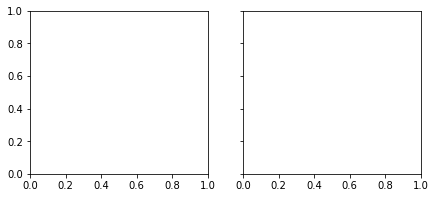

In [25]:
test = plot_data['$RO_{20yr}$']['Historical']['bcsd']
test
test.plot(robust=True, col='gcm')

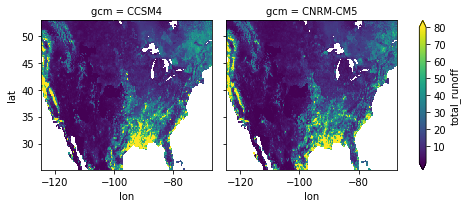

In [22]:
test = plot_data['$RO_{20yr}$']['Historical']['loca']
test
test.plot(robust=True, col='gcm')

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [ ]:
kwargs = {'$RO_{20yr}$': {'vmin': 0, 'vmax': 120},
          '$7RO10$': {'vmin': 0, 'vmax': 0.6}}

var = 'total_runoff'
subcols = ['Historical', 'RCP 4.5', 'RCP 8.5']

# TODO: Fix mask issue with LOCA

for stat, data in plot_data.items():

    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, title in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                data[title][dset].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[stat])
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()    


In [ ]:
diff_kws = {'ET': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu'},
            'total_runoff': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu'}}

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
    
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                if 'RCP' in title:
                    (ds_dict[dset][var].sel(gcm=model) - hist_means[dset][var].sel(gcm=model)).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
                else:
                    ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout() 


In [ ]:
plt.close('all')